In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('../modules')
from FSC import GenerationDiscreteObs as FSC_DiscreteObs
from FSC import InferenceDiscreteObs as FSC_InferenceDiscreteObs
from FSC_DoubleGrad import InferenceDiscreteObs as FSC_DoubleGrad_InferenceDiscreteObs
import ObsModels 

In [4]:
# set matplotlib font to avenir
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Avenir'

In [108]:
import numba as nb

@nb.njit
def optimize_rho(TMat, pya, rhok, maxiter, th = 1e-6):

    Y, M, A, _ = TMat.shape

    wVec = np.zeros((Y, A, M))
    for y in range(Y):
        for a in range(A):
            for m in range(M):
                wVec[y, a, m] = np.sum(TMat[y, m, :, a])

    for _ in range(maxiter):
        wsumexp_test_k = np.zeros((Y, A))
        
        for y in range(Y):
            for a in range(A):
                wsumexp_test_k[y, a] = np.sum(wVec[y, a] * rhok)
        
        grad = wVec * rhok / wsumexp_test_k[..., None]

        rhok_new = np.zeros(M)

        for y in range(Y):
            for a in range(A):
                rhok_new += pya[y, a] * grad[y, a]
        
        # if np.linalg.norm(rhok_new - rhok) < th:
        #     break

        rhok_new /= np.sum(rhok_new)

        rhok = rhok_new

    return rhok

In [132]:
M_array = np.arange(2, 5, 1)
Y_array = np.arange(2, 5, 1)
A_array = np.arange(2, 5, 1)

NTraj_array = np.array([100, 250, 500, 1000, 5000, 10000])

NStepsObs = 1
NSteps = NStepsObs

MaxIter = 10000
NSamples = 100

L = np.zeros((len(Y_array), len(A_array), len(M_array), len(NTraj_array), NSamples))

for idx_sample in range(NSamples):
    print(f'Sample {idx_sample+1}/{NSamples}')
    for idx_y, Y in enumerate(Y_array):
        RateMatrixObs = np.ones((Y,Y))
        RateMatrixObs = RateMatrixObs + 2*np.eye(Y)

        for idx_traj, NTraj in enumerate(NTraj_array):

            observations = ObsModels.DiscreteMarkovChain(NTraj, NStepsObs, RateMatrixObs)

            for idx_a, A in enumerate(A_array):

                for idx_m, M in enumerate(M_array):

                    Theta = np.random.randn(Y, M, M, A)
                    Psi = np.random.randn(M)

                    FSC = FSC_DiscreteObs(Theta, Psi, verbose = False)
                    FSC.load_observations(observations)

                    trajectories = FSC.generate_trajectories(NSteps)

                    ya_array = np.array([[tr['observations'][0], tr['actions'][0]]  for tr in trajectories])

                    hist = np.histogram2d(ya_array[:,0], ya_array[:,1], bins = [np.arange(Y+1), np.arange(A+1)])[0]
                    pya = hist / np.sum(hist)
                    pAgY = pya / np.sum(pya, axis = 1)[:, None]

                    rhostart = np.random.rand(M)
                    rhostart /= np.sum(rhostart)

                    rho_opt = optimize_rho(FSC.TMat, pya, rhostart, MaxIter)

                    wVec = FSC.TMat.sum(axis = 2).transpose(0, 2, 1)
                    L[idx_y, idx_a, idx_m, idx_traj, idx_sample] = np.sum(pya*np.log(pAgY/np.sum((wVec*rho_opt), axis = -1)))


Sample 1/100


/var/folders/tq/vdh27z_571gbg17w072s1p7h0000gn/T/ipykernel_26823/1687364998.py:49: RuntimeWarning: divide by zero encountered in log
  L[idx_y, idx_a, idx_m, idx_traj, idx_sample] = np.sum(pya*np.log(pAgY/np.sum((wVec*rho_opt), axis = -1)))
/var/folders/tq/vdh27z_571gbg17w072s1p7h0000gn/T/ipykernel_26823/1687364998.py:49: RuntimeWarning: invalid value encountered in multiply
  L[idx_y, idx_a, idx_m, idx_traj, idx_sample] = np.sum(pya*np.log(pAgY/np.sum((wVec*rho_opt), axis = -1)))


Sample 2/100
Sample 3/100
Sample 4/100
Sample 5/100
Sample 6/100
Sample 7/100
Sample 8/100
Sample 9/100
Sample 10/100
Sample 11/100
Sample 12/100
Sample 13/100
Sample 14/100
Sample 15/100
Sample 16/100
Sample 17/100
Sample 18/100
Sample 19/100


/var/folders/tq/vdh27z_571gbg17w072s1p7h0000gn/T/ipykernel_26823/1687364998.py:49: RuntimeWarning: invalid value encountered in log
  L[idx_y, idx_a, idx_m, idx_traj, idx_sample] = np.sum(pya*np.log(pAgY/np.sum((wVec*rho_opt), axis = -1)))


Sample 20/100
Sample 21/100
Sample 22/100
Sample 23/100
Sample 24/100
Sample 25/100
Sample 26/100
Sample 27/100
Sample 28/100
Sample 29/100
Sample 30/100
Sample 31/100
Sample 32/100
Sample 33/100
Sample 34/100
Sample 35/100
Sample 36/100
Sample 37/100
Sample 38/100
Sample 39/100
Sample 40/100
Sample 41/100
Sample 42/100
Sample 43/100
Sample 44/100
Sample 45/100
Sample 46/100
Sample 47/100
Sample 48/100
Sample 49/100
Sample 50/100
Sample 51/100
Sample 52/100
Sample 53/100
Sample 54/100
Sample 55/100
Sample 56/100
Sample 57/100
Sample 58/100
Sample 59/100
Sample 60/100
Sample 61/100
Sample 62/100
Sample 63/100
Sample 64/100
Sample 65/100
Sample 66/100
Sample 67/100
Sample 68/100
Sample 69/100
Sample 70/100
Sample 71/100
Sample 72/100
Sample 73/100
Sample 74/100
Sample 75/100
Sample 76/100
Sample 77/100
Sample 78/100
Sample 79/100
Sample 80/100
Sample 81/100
Sample 82/100
Sample 83/100
Sample 84/100
Sample 85/100
Sample 86/100
Sample 87/100
Sample 88/100
Sample 89/100
Sample 90/100
Sample

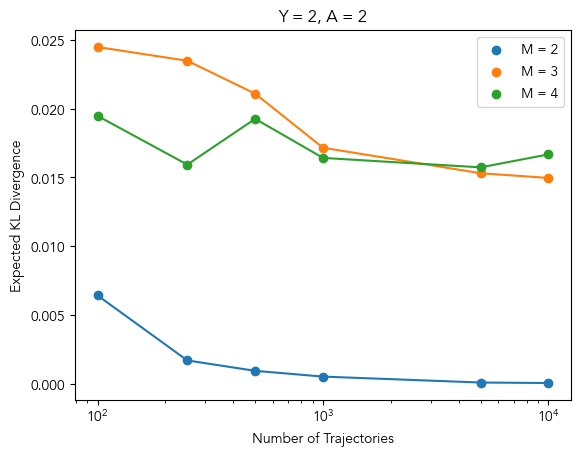

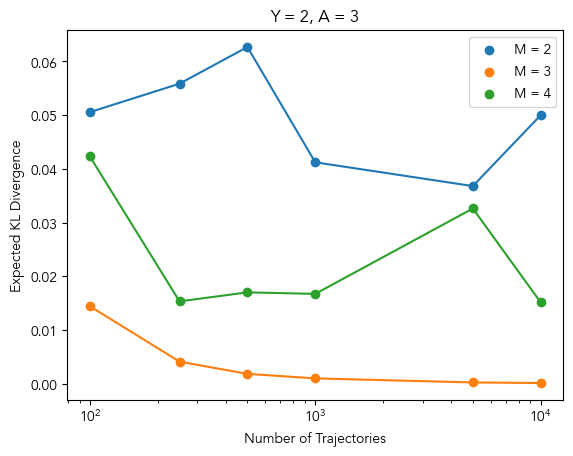

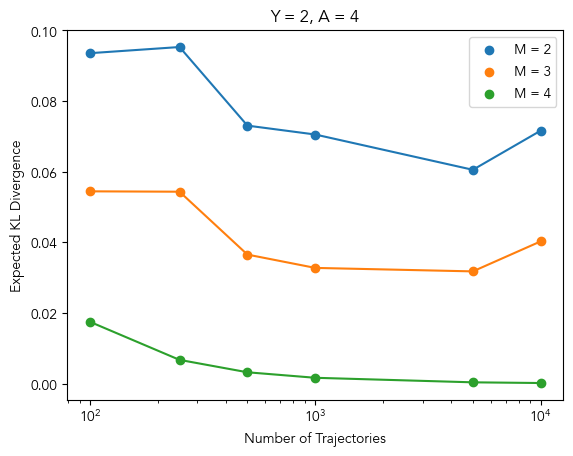

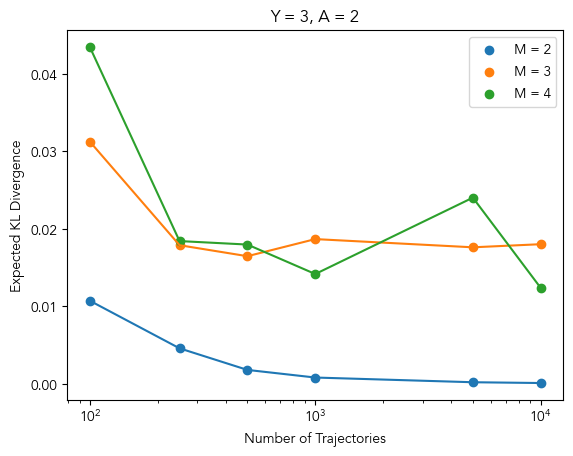

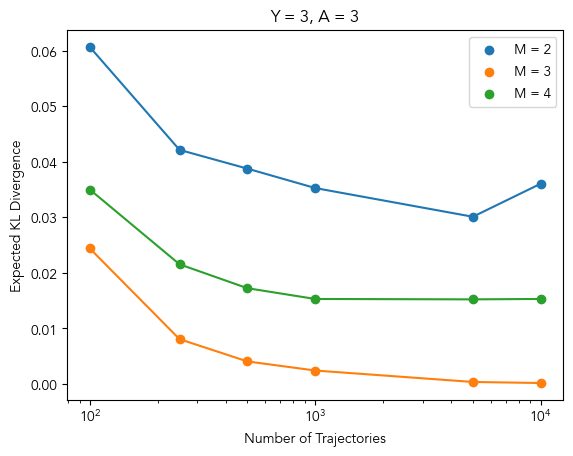

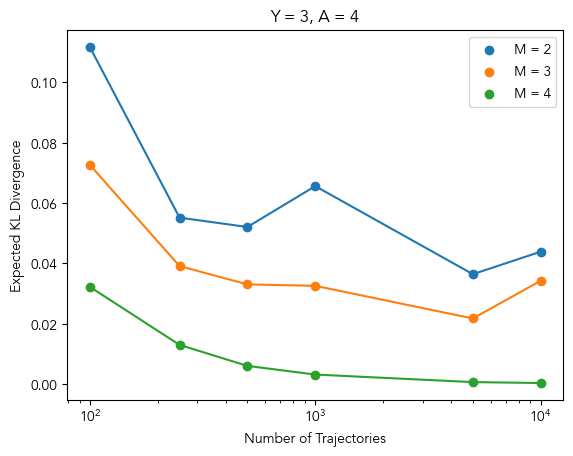

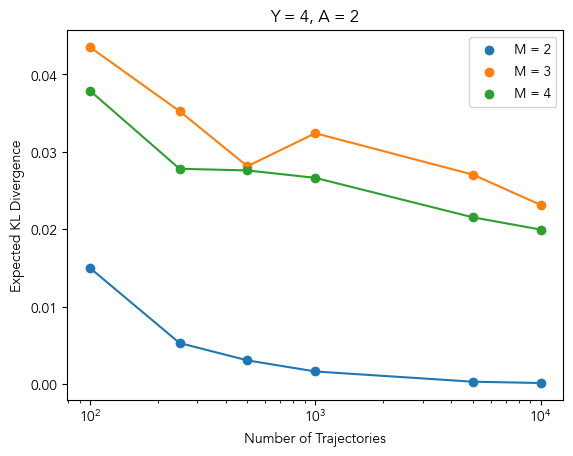

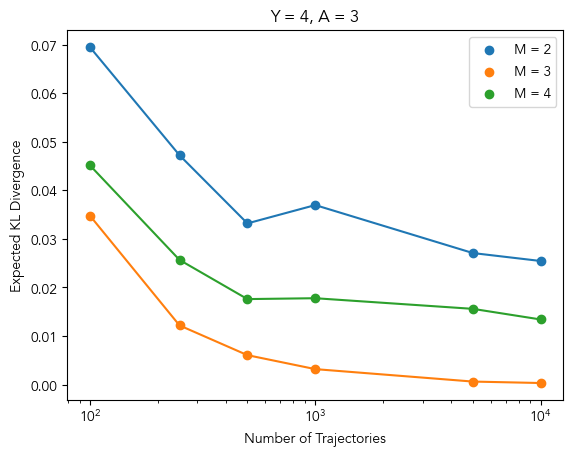

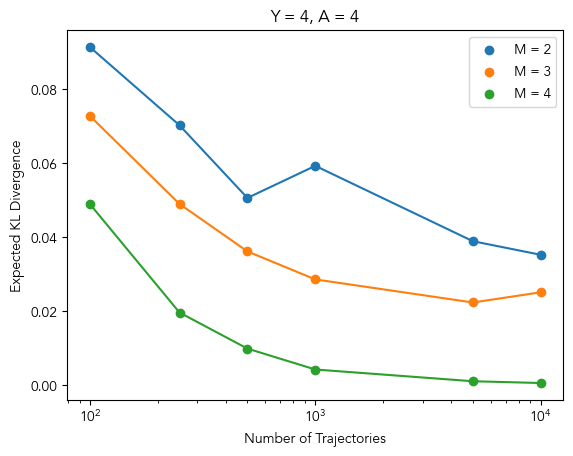

In [138]:
for idx_y, Y in enumerate(Y_array):
    for idx_a, A in enumerate(A_array):
        fig, ax = plt.subplots()
        ax.set_title(f'Y = {Y}, A = {A}')
        for idx_m, M in enumerate(M_array):
            current_L = L[idx_y, idx_a, idx_m]

            #plt.errorbar(NTraj_array, np.mean(current_L, axis = 1), yerr = np.std(current_L, axis = 1), label = f'Y = {Y}, A = {A}, M = {M}')
            ax.scatter(NTraj_array, np.nanmean(current_L, axis = 1), label = f'M = {M}')
            ax.plot(NTraj_array, np.nanmean(current_L, axis = 1))

        ax.legend(bbox_to_anchor = (1,1))
        ax.set_xscale('log')
        ax.set_xlabel('Number of Trajectories')
        ax.set_ylabel('Expected KL Divergence')
        plt.show()

In [112]:
rho_opt

array([0.67866629, 0.21435286, 0.10698085])

In [113]:
ttest

array([[0.54809215, 0.45190785],
       [0.55142498, 0.44857502]])

In [114]:
np.sum(pAgY[0]*np.log(pAgY[0]/ttest[0]))

1.40391272718224e-05

In [ ]:
np.sum(pAgY*np.log(pAgY/np.sum((wVec*rho_opt), axis = -1)), axis = 1)

array([-0.00437779, -0.01054086, -0.00077371, -0.00776107])

In [29]:
Y = 3
A = 2
M = 2
NTraj = 500

RateMatrixObs = np.ones((Y,Y))
RateMatrixObs = RateMatrixObs + 2*np.eye(Y)
observations = ObsModels.DiscreteMarkovChain(NTraj, NStepsObs, RateMatrixObs)

Theta = np.random.randn(Y, M, M, A)
Psi = np.random.randn(M)

FSC = FSC_DiscreteObs(Theta, Psi, verbose = True)
FSC.load_observations(observations)

trajectories = FSC.generate_trajectories(NSteps)

ya_array = np.array([[tr['observations'][0], tr['actions'][0]]  for tr in trajectories])

hist = np.histogram2d(ya_array[:,0], ya_array[:,1], bins = [np.arange(Y+1), np.arange(A+1)])[0]
pya = hist / np.sum(hist)

FSC_tofit = FSC_InferenceDiscreteObs(M, A, Y, seed = 123)
FSC_tofit.load_theta(Theta.astype(np.float32))
FSC_tofit.load_trajectories(trajectories)

Initializing FSC with 2 memory states, 2 actions, and 3 observations.


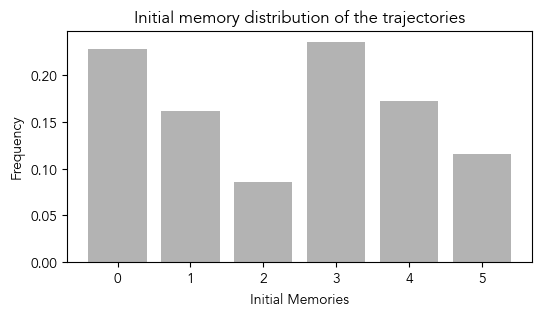

In [9]:
initial_memories = np.array([tr["memories"][0] for tr in trajectories])

fig, ax = plt.subplots(1,1, figsize=(6,3))

h, bins_h = np.histogram(initial_memories.flatten(), bins = np.arange(-0.5, M+0.5, 1))
h = h/np.sum(h)
bins_h = (bins_h[1:] + bins_h[:-1])/2

ax.bar(bins_h, h, width = 0.8, color = 'dimgray', alpha = 0.5)

ax.set_xlabel('Initial Memories')
ax.set_ylabel('Frequency')

ax.set_xticks(np.arange(0, M, 1))

ax.set_title('Initial memory distribution of the trajectories')

plt.show()

In [11]:
FSC.evaluate_nloglikelihood(trajectories[0])

0.5981997574758989

### Inference (gradient-based)

In [12]:
FSC_tofit = FSC_InferenceDiscreteObs(M, A, Y, seed = 123)
FSC_tofit.load_theta(Theta.astype(np.float32))
FSC_tofit.load_trajectories(trajectories)
FSC_tofit.evaluate_nloglikelihood(idx_traj = 0)

tensor(0.5254, device='mps:0', grad_fn=<SubBackward0>)

In [13]:
psi_pre_fit = FSC_tofit.psi.detach().cpu().numpy()
rho_pre_fit = FSC_tofit.rho.detach().cpu().numpy()

In [14]:
MSE = FSC_tofit.optimize_psionly(maxiter = 10000, th = 1e-15, rho0 = np.ones(M))

In [15]:
MSE, FSC_tofit.rho

(0.0, tensor([0.1950, 0.1403, 0.1442, 0.2231, 0.1195, 0.1779], device='mps:0'))

In [17]:
optimize_rho(FSC_tofit.TMat.detach().cpu().numpy(), FSC_tofit.pStart_ya_emp, np.ones(M)/M, 20000)

array([0.19496627, 0.14031046, 0.14420426, 0.22310752, 0.11948549,
       0.177926  ])

### Comparison

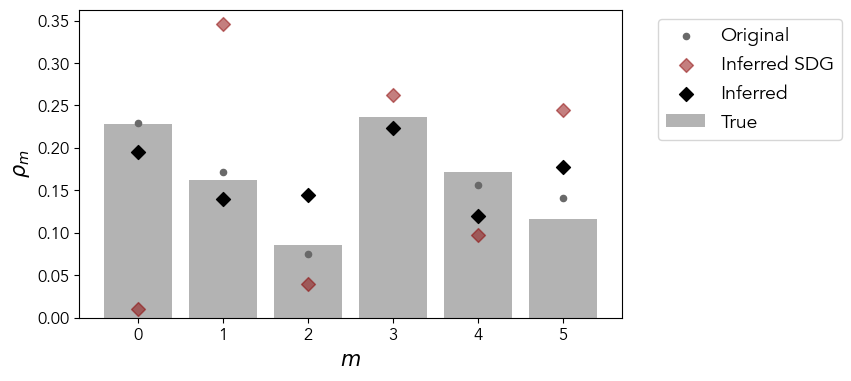

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(7,4))
ax.bar(bins_h, h, color = "dimgray", alpha = 0.5, label = "True")
ax.scatter(np.arange(M), FSC.rho, color = "dimgray", marker = "o", s = 20, label = "Original")

ax.scatter(np.arange(M), FSC_SDG.rho.detach().cpu(), color = "darkred", marker = "D", s = 50, label = "Inferred SDG", alpha = 0.5)
#ax.scatter(np.arange(M), rho_pre_fit_SDG, color = "darkred", marker = "x", s = 50, label = "Pre-fit SDG", alpha = 0.5)

ax.scatter(np.arange(M), FSC_tofit.rho.cpu(), color = "black", marker = "D", s = 50, label = "Inferred")
#ax.scatter(np.arange(M), rho_pre_fit, color = "black", marker = "x", s = 50, label = "Pre-fit")

ax.set_xlabel("$m$", fontsize = 15)
ax.set_ylabel("$\\rho_m$", fontsize = 15)

ax.tick_params(axis='both', which='major', labelsize=12)

plt.legend(fontsize = 14, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

In [ ]:
wVec = FSC_tofit.TMat.detach().cpu().numpy().sum(axis = 2).transpose(0,2,1)

-np.sum(FSC_tofit.pStart_ya_emp*np.log(np.sum((wVec*FSC_SDG.rho.detach().cpu().numpy()), axis = -1)))

0.701305176615715

In [ ]:
-np.sum(FSC_tofit.pStart_ya_emp*np.log(np.sum((wVec*FSC_tofit.rho.detach().cpu().numpy()), axis = -1)))

0.6881254379749298

In [ ]:
-np.sum(FSC_tofit.pStart_ya_emp*np.log(np.sum((wVec*FSC.rho), axis = -1)))

0.6884107400127863

In [ ]:
-np.sum(FSC_tofit.pStart_ya_emp*np.log(np.sum((wVec*h), axis = -1)))

0.6883623732011349